In [2]:
import numpy as np
import pandas as  pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import time
import matplotlib.pyplot as plt
import seaborn

In [3]:
from dask_ml.datasets import make_classification

In [4]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:57326 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.50 GB


In [5]:
start_time = time.time()
dataset = dd.read_csv("../data/raw/train_ctrUa4K.csv")
time_duration =  time.time() - start_time
print("time duration for dataset to read {}".format(time_duration))

time duration for dataset to read 0.03019261360168457


In [6]:
with ProgressBar():
    dataset = dataset.drop("Loan_ID",axis=1)

In [7]:
dataset.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
target = dataset.Loan_Status
with ProgressBar():
    data = dataset.drop("Loan_Status",axis=1)
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [10]:
data.describe().compute()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,599.000000,614.000000,614.000000,592.000000,600.00000,564.000000
mean,0.848080,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,1.220762,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,0.000000,150.000000,0.000000,9.000000,12.00000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,0.000000,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,2.000000,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,4.000000,81000.000000,41667.000000,700.000000,480.00000,1.000000


## Missing Values

In [11]:
feature_with_na = [feature for feature in data.columns if data[feature].isnull().sum()>1]
for feature in feature_with_na:
    print("{} have {} % of missing value".format(feature,np.round(data[feature].isnull().mean(),4)))

Gender have 0.0212 % of missing value
Married have 0.0049 % of missing value
Dependents have 0.0244 % of missing value
Education have 0.0 % of missing value
Self_Employed have 0.0521 % of missing value
ApplicantIncome have 0.0 % of missing value
CoapplicantIncome have 0.0 % of missing value
LoanAmount have 0.0358 % of missing value
Loan_Amount_Term have 0.0228 % of missing value
Credit_History have 0.0814 % of missing value
Property_Area have 0.0 % of missing value


## Numerical Variable

In [12]:
numerical_features = [feature for feature in data.columns if data[feature].compute().dtypes != 'O']
numerical_features

['Dependents',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [13]:
# check descrete variables
descrete_features = [feature for feature in numerical_features if len(dataset[feature].compute().unique()) < 25]
descrete_features

['Dependents', 'Loan_Amount_Term', 'Credit_History']

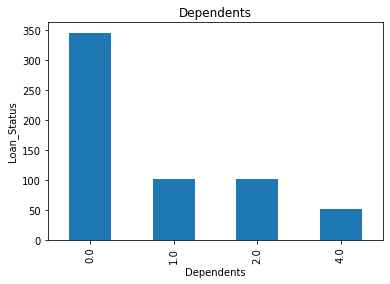

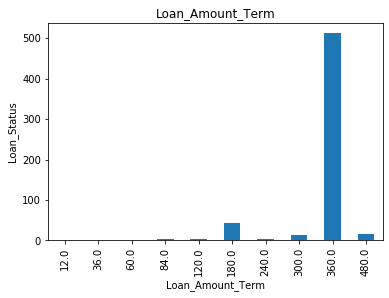

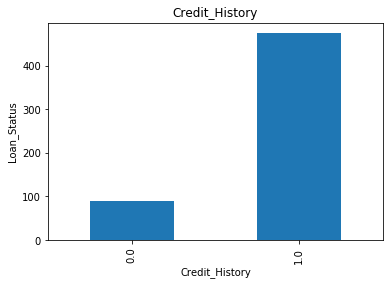

In [14]:
for feature in descrete_features:
    temp_data = dataset.copy()
    temp_data.groupby(feature).Loan_Status.count().compute().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Loan_Status')
    plt.title(feature)
    plt.show()

In [15]:
# check for continuous variables
continuous_features = [feature for feature in numerical_features if feature not in descrete_features]
continuous_features

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

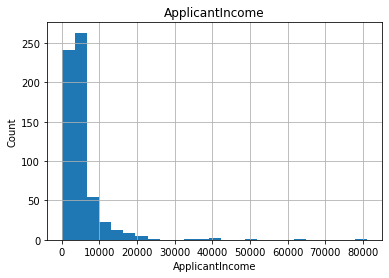

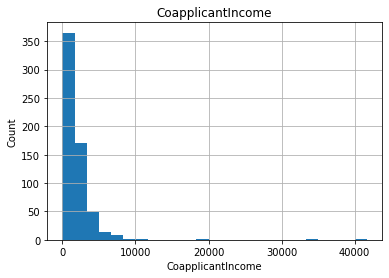

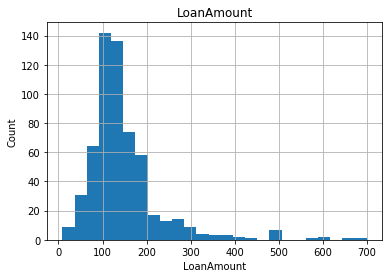

In [16]:
# Distribution of continuous variable
for feature in continuous_features:
    temp_data = data.copy()
    temp_data[feature].compute().hist(bins = 25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

Continous variables are right skewed. Need to do log/sqrt/boxcox trtansformation

## Catagorical Variables

In [17]:
catagorical_features = [feature for feature in data.columns if data[feature].compute().dtypes == 'O']
for feature in catagorical_features:
    print("{} contain {} catagories".format(feature,len(data[feature].unique())))

Gender contain 3 catagories
Married contain 3 catagories
Education contain 2 catagories
Self_Employed contain 3 catagories
Property_Area contain 3 catagories


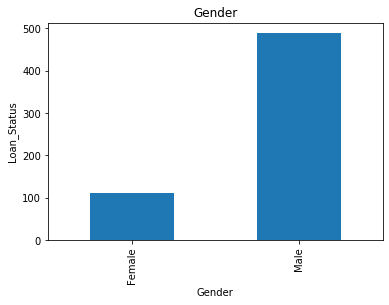

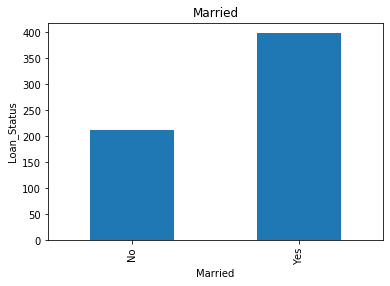

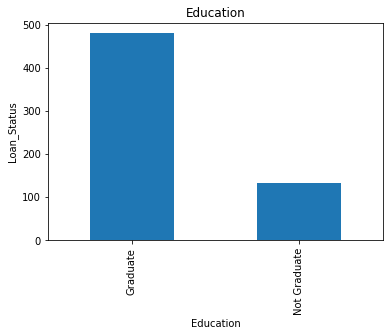

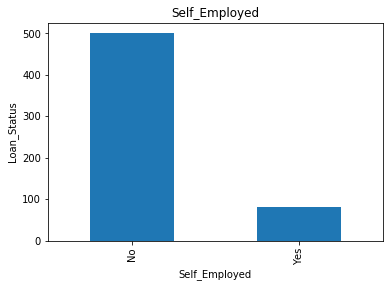

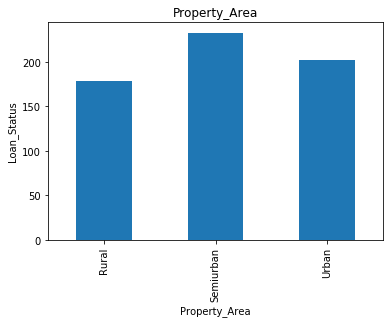

In [18]:
# relation between catagorical features and dependent variable
for feature in catagorical_features:
    temp_data = dataset.copy()
    temp_data.groupby(feature).Loan_Status.count().compute().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Loan_Status')
    plt.title(feature)
    plt.show()

## Missing Value Imputation

### Catagorical Features

In [22]:
def cat_feature_na(X_train):
    catagorical_features_na = [feature for feature in X_train.columns if X_train[feature].isnull().sum().compute()>1 and X_train[feature].compute().dtypes == 'O']
    return catagorical_features_na
catagorical_feature_NA = cat_feature_na(data)

In [41]:
for feature in catagorical_feature_NA:
    print("{} contains {} % NaN values".format(feature,np.round(data[feature].isnull().mean().compute()*100,4)))

Gender contains 2.1173 % NaN values
Married contains 0.4886 % NaN values
Self_Employed contains 5.2117 % NaN values


In [44]:
def impute_catagorical_na(dataset,catagorical_features_na):
    data = dataset.copy()
    for feature in catagorical_features_na:
        data[feature] = data[feature].fillna('Missing')
    return data
data_clean1 = impute_catagorical_na(data,catagorical_feature_NA)

In [45]:
for feature in catagorical_feature_NA:
    print("{} contains {} % NaN values".format(feature,np.round(data_clean1[feature].isnull().mean().compute()*100,4)))

Gender contains 0.0 % NaN values
Married contains 0.0 % NaN values
Self_Employed contains 0.0 % NaN values


### Numerical Features

In [46]:
# Numerical features
numerical_features_na = [feature for feature in data_clean1.columns if data_clean1[feature].isnull().sum().compute()>1 and data_clean1[feature].compute().dtypes != 'O']
for feature in numerical_features_na:
    print("{} contains {} % NaN values".format(feature,np.round(data_clean1[feature].isnull().mean(),4)))

Dependents contains 0.0244 % NaN values
LoanAmount contains 0.0358 % NaN values
Loan_Amount_Term contains 0.0228 % NaN values
Credit_History contains 0.0814 % NaN values


In [67]:
def impute_numerical_na(dataset,numerical_features_na):
    for feature in numerical_features_na:
        median_value = dataset[feature].mean().compute()
        dataset[feature] = dataset[feature].fillna(median_value)
    return dataset

data_clean2 = impute_numerical_na(data_clean1,numerical_features_na)

In [68]:
data_clean2[numerical_features_na].isnull().sum().compute()


Dependents          0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64

In [69]:
feature_NA = [feature for feature in data_clean2.columns if data_clean2[feature].isnull().sum()>1]
for feature in feature_NA:
    print("{} have {} % of missing value".format(feature,np.round(data_clean2[feature].isnull().mean(),4)))

Gender have 0.0 % of missing value
Married have 0.0 % of missing value
Dependents have 0.0 % of missing value
Education have 0.0 % of missing value
Self_Employed have 0.0 % of missing value
ApplicantIncome have 0.0 % of missing value
CoapplicantIncome have 0.0 % of missing value
LoanAmount have 0.0 % of missing value
Loan_Amount_Term have 0.0 % of missing value
Credit_History have 0.0 % of missing value
Property_Area have 0.0 % of missing value


In [72]:
data_clean2.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0.0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban
4,Male,No,0.0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban


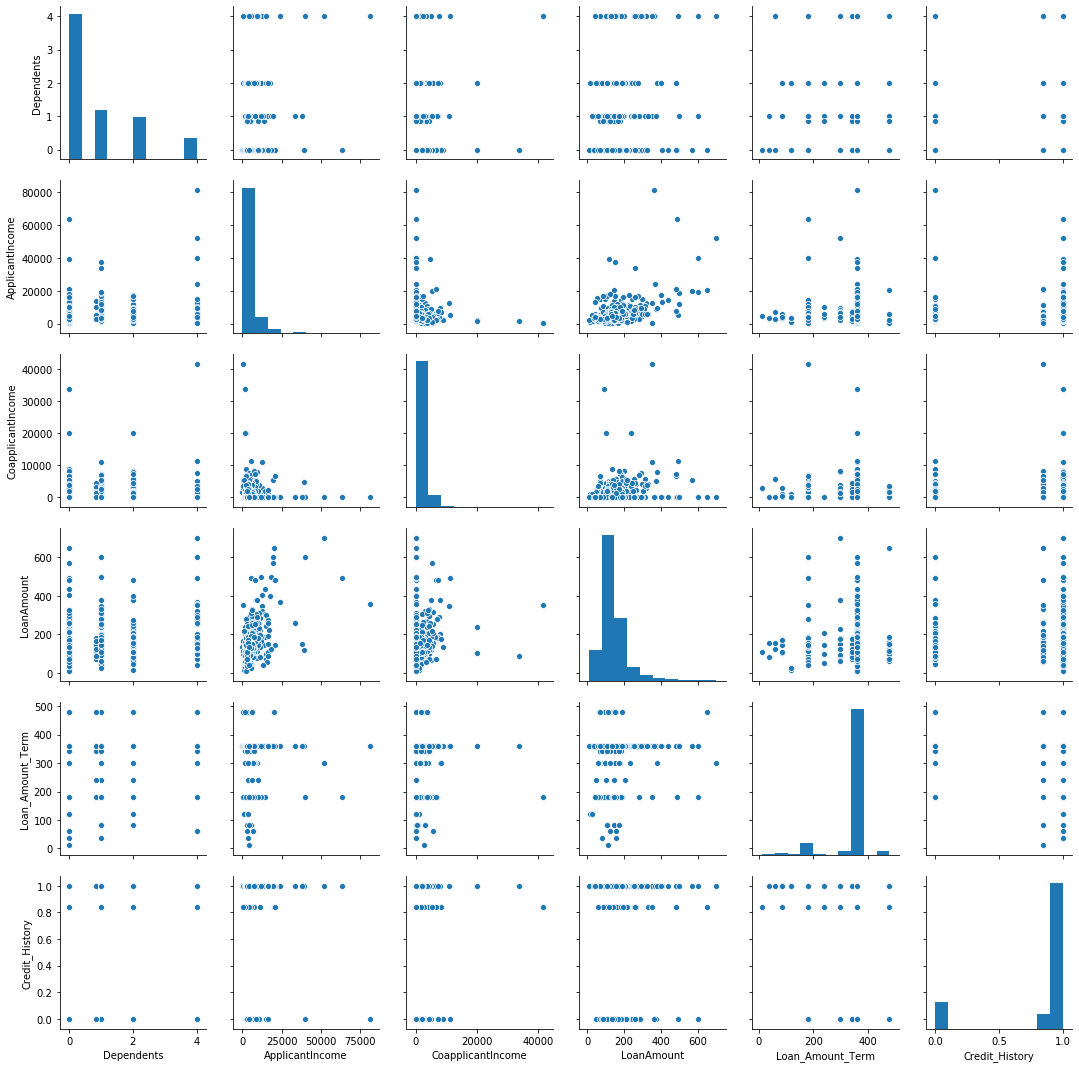

In [153]:
seaborn.pairplot(data_clean2.compute())

In [93]:
encode_data = [feature for feature in data_clean2.columns if len(data_clean2[feature].unique())<=5]
encode_data

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area']

In [109]:
from dask_ml.preprocessing import LabelEncoder,DummyEncoder,MinMaxScaler

In [106]:

df = data_clean2.compute()
data_clean3 = DummyEncoder().fit_transform(df)
data_clean3.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Gender_Missing,Married_Missing,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_Missing,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.0,5849,0.0,146.412162,360.0,1.0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
1,1.0,4583,1508.0,128.000000,360.0,1.0,0,1,0,0,0,1,1,0,0,1,0,1,0,0
2,0.0,3000,0.0,66.000000,360.0,1.0,0,1,0,0,0,1,1,0,0,0,1,0,0,1
3,0.0,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,0,1,0,1,0,1,0,0,0,1
4,0.0,6000,0.0,141.000000,360.0,1.0,0,1,0,0,1,0,1,0,0,1,0,0,0,1


In [108]:
data_clean4 = dd.from_pandas(data_clean3,npartitions=3)
data_clean4.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Gender_Missing,Married_Missing,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_Missing,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.0,5849,0.0,146.412162,360.0,1.0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
1,1.0,4583,1508.0,128.000000,360.0,1.0,0,1,0,0,0,1,1,0,0,1,0,1,0,0
2,0.0,3000,0.0,66.000000,360.0,1.0,0,1,0,0,0,1,1,0,0,0,1,0,0,1
3,0.0,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,0,1,0,1,0,1,0,0,0,1
4,0.0,6000,0.0,141.000000,360.0,1.0,0,1,0,0,1,0,1,0,0,1,0,0,0,1


In [139]:
scaler = MinMaxScaler()
data_clean5 = scaler.fit_transform(data_clean4)
data_clean5.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Gender_Missing,Married_Missing,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_Missing,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.00,0.070489,0.000000,0.198860,0.74359,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.25,0.054830,0.036192,0.172214,0.74359,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.00,0.035250,0.000000,0.082489,0.74359,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.00,0.030093,0.056592,0.160637,0.74359,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.00,0.072356,0.000000,0.191027,0.74359,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [140]:
data_clean6 = data_clean5.compute()
#data_clean5.to_csv("../data/intermediate/data_clean5.csv",index=False)

In [141]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import sklearn

sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [142]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)

In [148]:
data_arr = data_clean6.to_numpy()
target_arr  = np.array(target)

In [149]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(data_arr, target_arr)

In [150]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.054373,0.038109,0.002996,0.000814,0.001,rbf,True,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': True}",0.687805,0.687805,0.686275,0.687296,0.000721,25
1,0.029255,0.001696,0.003331,0.000481,0.001,rbf,False,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': False}",0.687805,0.687805,0.686275,0.687296,0.000721,25
2,0.020616,0.001693,0.001990,0.000815,0.001,poly,True,"{'C': 0.001, 'kernel': 'poly', 'shrinking': True}",0.687805,0.687805,0.686275,0.687296,0.000721,25
3,0.020610,0.002048,0.002671,0.000455,0.001,poly,False,"{'C': 0.001, 'kernel': 'poly', 'shrinking': Fa...",0.687805,0.687805,0.686275,0.687296,0.000721,25
4,0.027650,0.002059,0.003266,0.001020,0.001,sigmoid,True,"{'C': 0.001, 'kernel': 'sigmoid', 'shrinking':...",0.687805,0.687805,0.686275,0.687296,0.000721,25


In [151]:
grid_search.score(data_arr, target_arr)

0.8094462540716613